In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Hypothesis 1: NayveBayes

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [5]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    roc_scorer = make_scorer(accuracy_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=roc_scorer)
    print(roc_aucs)

In [4]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
print("GaussianNB: " + str(precision))

# Check transformed data

model = BernoulliNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
print("BernoulliNB: " + str(precision))

# Check transformed data

model = MultinomialNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
print("MultinomialNB: " + str(precision))

GaussianNB: 0.2168954938644136
BernoulliNB: 0.19164151214603997
MultinomialNB: 0.1981085571358151


In [4]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']


    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    roc_scorer = make_scorer(accuracy_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=roc_scorer)
    print(roc_aucs)

In [6]:
model = CategoricalNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
print("CategoricalNB: " + str(precision))

CategoricalNB: 0.1924401156260932


# Predict

In [6]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    roc_scorer = make_scorer(accuracy_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=roc_scorer)
    print(roc_aucs)

In [7]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

In [8]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

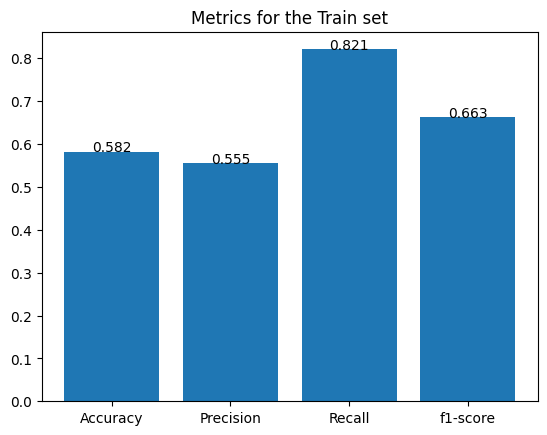

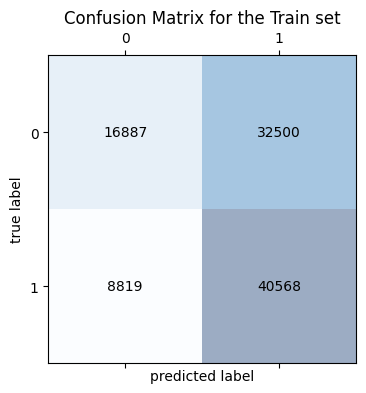

In [9]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

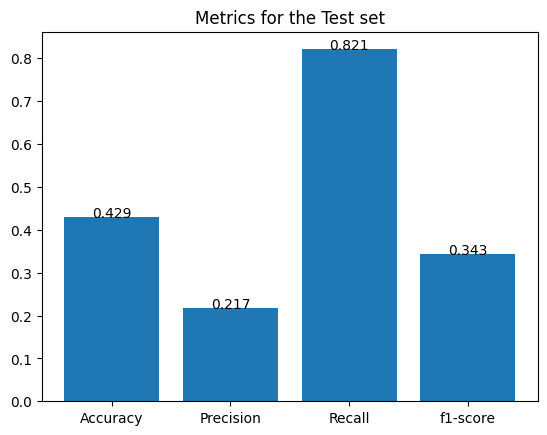

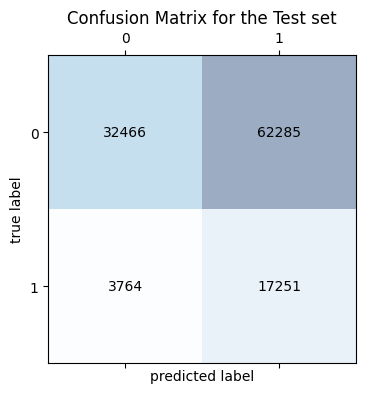

In [10]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

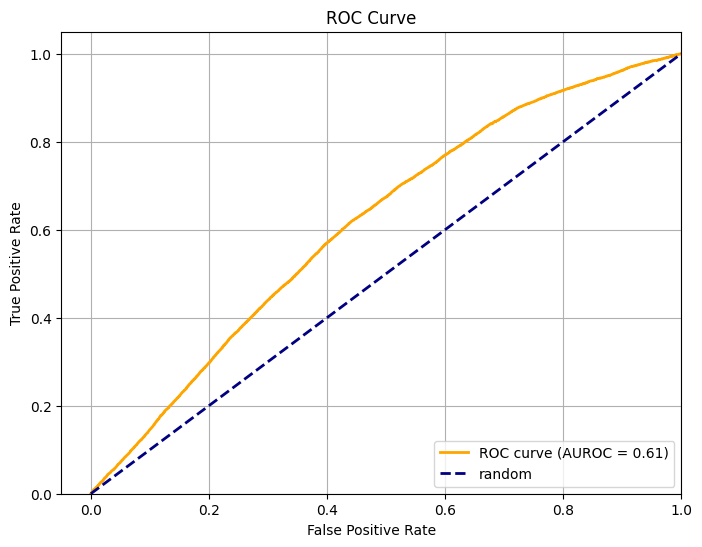

In [11]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [12]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.2168954938644136)

In [16]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=1)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    display(problematic_departments)
else:
    print("Requirement satisfied!")

Race
Requirement failed
Global rates: {'White': 0.21951058528455686, 'Black': 0.22812311406155703, 'Asian': 0.18968169447402675, 'Mixed': 0.25113464447806355, 'Other': 0.18815104166666666}
Num problematic departments: 30
Num good departments: 7
avg diff: 0.15077572265260672


[('hampshire',
  0.055454657013130404,
  {'White': 0.31661121064755565,
   'Black': 0.26868327402135234,
   'Asian': 0.27636363636363637,
   'Other': 0.32413793103448274}),
 ('devon-and-cornwall',
  0.16832579185520363,
  {'White': 0.20186461289014998,
   'Black': 0.18461538461538463,
   'Asian': 0.18604651162790697,
   'Other': 0.35294117647058826}),
 ('north-wales',
  0.2916666666666667,
  {'White': 0.1710261569416499,
   'Black': 0.08333333333333333,
   'Asian': 0.375,
   'Other': 0.10256410256410256}),
 ('suffolk',
  0.0789156626506024,
  {'White': 0.21274900398406374,
   'Black': 0.15,
   'Asian': 0.18181818181818182,
   'Mixed': 0.2289156626506024,
   'Other': 0.21212121212121213}),
 ('thames-valley',
  0.0664819944598338,
  {'White': 0.2135683999107342,
   'Black': 0.2194732641660016,
   'Asian': 0.1835180055401662,
   'Other': 0.25}),
 ('kent',
  0.09842047145806329,
  {'White': 0.21479862628785515,
   'Black': 0.24936386768447838,
   'Asian': 0.19,
   'Mixed': 0.24516129032258

In [17]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=1)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Gender
Requirement failed
Global rates: {'Male': 0.22260141384304336, 'Female': 0.17670807453416149, 'Other': 0.145985401459854}
Num problematic departments: 21
Num good departments: 16
avg diff: 0.08664221586134303


In [18]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=1)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.22269599767419324, '10-17': 0.17132473825387212, '18-24': 0.257116240554808, 'over 34': 0.175779756377342, 'under 10': 0.09803921568627451}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.14237471734212812


# Hypothesis 2: GradientBoosting

# Get the data

In [19]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [20]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    # numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols)
        # ,
        # ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

In [5]:
y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
learning_rate = [.1, .5, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)

for k in range(len(max_depths)):
    d = max_depths[k]
    print("max_depths: " +str(d))
    values = {}
    for lr in learning_rate:
        print("  learning_rate: " +str(lr))
        yvalues = []
        for n in n_estimators:
            print("    n_estimators: " +str(n))
            model = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)

            pipeline, X_train, y_train = create_pipeline(df_train, model)


            y_pred_test = pipeline.predict(X_test)
            yvalues.append(precision_score(y_test, y_pred_test))
            print("        precision: " +str(precision_score(y_test, y_pred_test)))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_model = model
        values[lr] = yvalues

max_depths: 5
  learning_rate: 0.1
    n_estimators: 5
        precision: 0.2356426139516746
    n_estimators: 10
        precision: 0.23486787244443166
    n_estimators: 25
        precision: 0.23897804557928648
    n_estimators: 50
        precision: 0.24162125962679978
    n_estimators: 75
        precision: 0.24308151429846017
    n_estimators: 100
        precision: 0.24364806734131775
    n_estimators: 200
        precision: 0.2449474788271576
    n_estimators: 300
        precision: 0.24664607586916923
    n_estimators: 400
        precision: 0.24650007167088728
  learning_rate: 0.5
    n_estimators: 5
        precision: 0.24179783804285984
    n_estimators: 10
        precision: 0.2409914728445246
    n_estimators: 25
        precision: 0.24298278443113772
    n_estimators: 50
        precision: 0.24577535987675123
    n_estimators: 75
        precision: 0.24651812848390295
    n_estimators: 100
        precision: 0.24635673067518665
    n_estimators: 200
        precision: 0.2

In [6]:
best_model

GradientBoostingClassifier(max_depth=10, n_estimators=400)

In [8]:
pipeline, X_train, y_train = create_pipeline(df_train, best_model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)

,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.0,0.956522,0.5,0.485662,0.566156,0.0,0.216193,0.894157
1,0.666667,1.0,0.956522,0.166667,0.485662,0.566156,0.0,0.466633,0.525023
2,0.333333,1.0,0.73913,0.833333,0.485662,0.280888,0.0,0.340396,0.633601
3,0.0,0.0,0.782609,0.333333,0.540932,0.507837,0.0,0.236856,0.717487
4,0.666667,1.0,0.956522,0.166667,0.485662,0.566156,0.0,0.465632,0.520331
...,...,...,...,...,...,...,...,...,...
98653,1.0,1.0,1.0,0.333333,0.485662,0.566156,0.0,0.460684,0.512242
98654,1.0,1.0,0.913043,0.5,0.485662,0.566156,0.0,0.058827,0.33405
98655,0.333333,0.0,1.0,0.0,0.485662,0.566156,0.0,0.401513,0.870621
98656,0.333333,0.0,0.0,0.0,0.485662,0.566156,0.0,0.178236,0.748508


In [22]:
pipeline, X_train, y_train = create_pipeline(df_train, GradientBoostingClassifier(n_estimators=200, max_depth=10, learning_rate=0.1))

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)

ValueError: Shape of passed values is (98774, 7), indices imply (98774, 9)

# Predict

In [23]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

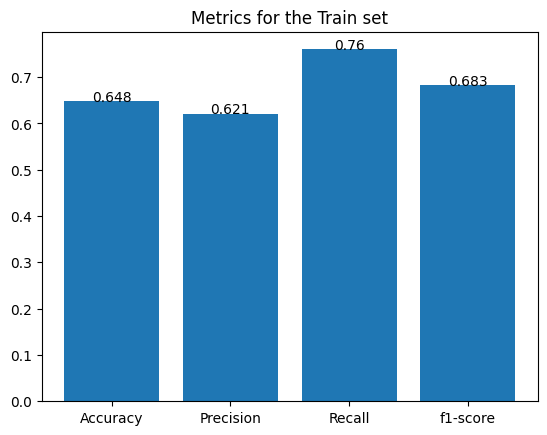

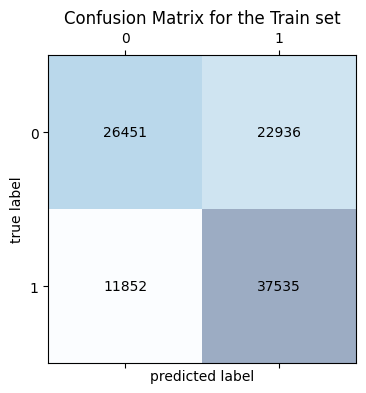

In [24]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

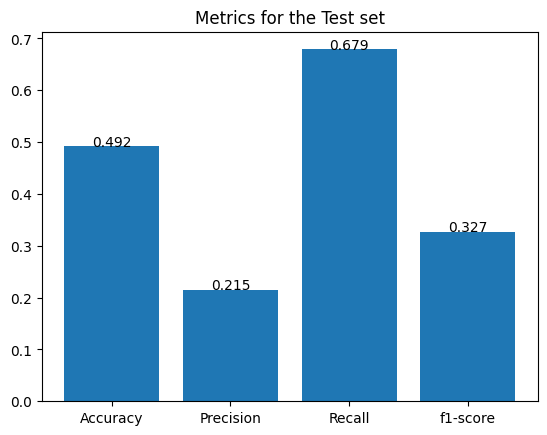

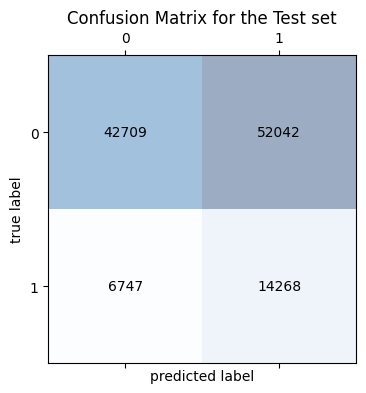

In [25]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

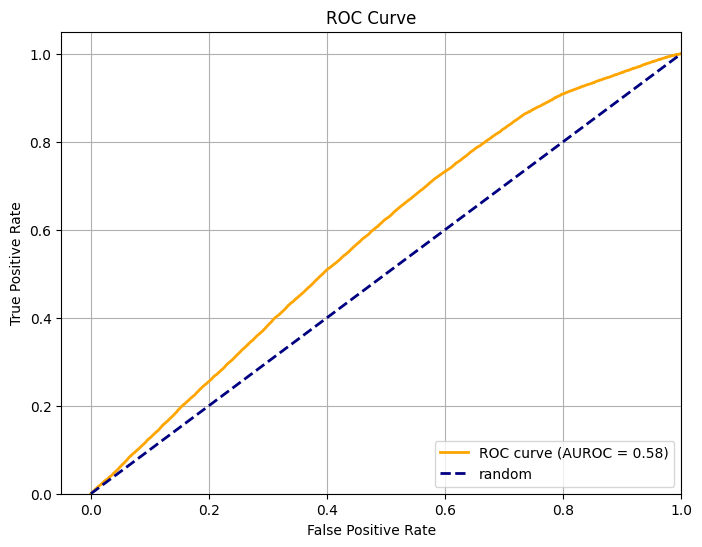

In [26]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

In [27]:
# Check client success rate req

aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.1)

(True, 0.2151711657366913)

In [28]:
# Check Race Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=5)

print("Race")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    display(problematic_departments)
else:
    print("Requirement satisfied!")

cumbriawas ignored
dyfed-powyswas ignored
lincolnshirewas ignored
durhamwas ignored
Race
Requirement failed
Global rates: {'White': 0.2179812900049237, 'Black': 0.22209008473316486, 'Asian': 0.18932455638236978, 'Mixed': 0.2560747663551402, 'Other': 0.19143968871595332}
Num problematic departments: 21
Num good departments: 12
avg diff: 0.12104806467135833


[('devon-and-cornwall',
  0.16666666666666666,
  {'White': 0.20696937697993664,
   'Black': 0.16666666666666666,
   'Asian': 0.21875,
   'Other': 0.3333333333333333}),
 ('north-wales',
  0.06236412090609439,
  {'White': 0.1950171821305842, 'Other': 0.1326530612244898}),
 ('suffolk',
  0.10310965630114569,
  {'White': 0.20491803278688525,
   'Black': 0.1276595744680851,
   'Asian': 0.13043478260869565,
   'Mixed': 0.19672131147540983,
   'Other': 0.23076923076923078}),
 ('thames-valley',
  0.06570247933884296,
  {'White': 0.2115333510496944,
   'Black': 0.22399250234301782,
   'Asian': 0.18429752066115704,
   'Other': 0.25}),
 ('kent',
  0.07871028923660503,
  {'White': 0.22164502164502164,
   'Black': 0.24344569288389514,
   'Asian': 0.17567567567567569,
   'Mixed': 0.2543859649122807,
   'Other': 0.17647058823529413}),
 ('surrey',
  0.18896321070234115,
  {'White': 0.2913907284768212,
   'Black': 0.1956521739130435,
   'Asian': 0.23129251700680273,
   'Mixed': 0.38461538461538464}),
 

In [29]:
# Check Gender Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Gender', max_diff=0.05, min_samples=5)

print("Gender")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

west-midlandswas ignored
lincolnshirewas ignored
Gender
Requirement failed
Global rates: {'Male': 0.22065405655685696, 'Female': 0.17587301587301588, 'Other': 0.13114754098360656}
Num problematic departments: 18
Num good departments: 17
avg diff: 0.10334745586575321


In [30]:
# Check Age Discrimination

is_satisfied, problematic_departments, good_deparments, global_precisions = aux_functions.verify_no_discrimination(X_test, y_test, y_pred_test, sensitive_column='Age range', max_diff=0.05, min_samples=5)

print("Age")

if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied!")

Age
Requirement failed
Global rates: {'25-34': 0.2193208430913349, '10-17': 0.16639577407557904, '18-24': 0.2552091946419712, 'over 34': 0.17857378455043207, 'under 10': 0.10256410256410256}
Num problematic departments: 35
Num good departments: 2
avg diff: 0.1281214338332316
